BE/Bi 103, Fall 2014: Homework 4
================================
Due 1pm, Monday, November 3
---------------------------

*This homework was generated from an IPython notebook.  You can download the notebook [here](hw4_solution.ipynb).*

In [1]:
# As usual, import modules
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

import numpy as np
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

import emcee
import triangle
from brewer2mpl import sequential

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

### Problem 4.1 (Working through tutorial 4 and MCMC, 10 pts)

We buzzed through tutorials 4a and 4b on Monday.  It is important that you understand all of the concepts and can execute the codes in those tutorials.
Work through [Tutorial 4a](http://bebi103.caltech.edu/2014/tutorials/t4a_nonlinear_regression.html) and [Tutorial 4b](http://bebi103.caltech.edu/2014/tutorials/t4b_model_selection.html).  Attach a Python script showing that you worked through the tutorial (you only need one per group; and you should be sure to discuss any points of confusion with your group).  Also, answer the following two questions.

**a)** Explain why marginalization is so easy to do after you have completed sampling the posterior using MCMC.

**b)** Use MCMC as in tutorial 4b to plot $P(\delta~|~D,I)$ for the case where $\delta = \sigma_\mathrm{GFP} - \sigma_\mathrm{wt}$, where $\sigma$ denotes gradient width.  Remember, $\sigma_\mathrm{GFP}$ is the mean gradient width as measured from GFP immunostaining and $\sigma_\mathrm{wt}$ is the mean gradient width as measured from Dorsal immunostaining in wild type.  *Hint*: After you worked through Tutorial 4b, you already know how to generate the MCMC traces.  It's just a matter of plotting the distribution.

### Problem 4.1 solution

**a)**  When we sample the posterior, we sample over all parameters.  If we look only at samples of one parameter, the influence of all the other parameters is present in the samples of the one parameter we are interested in.  This amounts to marginalizing over all parameters.  In this sense get the marginalization "for free."  All we have to do, is look at a particular parameter and ignore the rest!

**b)** Do exactly the same procedure as in the tutorial to get the MCMC traces, except using the GFP sample instead of Venus.

In [2]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#')

# Rename key columns
df.rename(columns={'wt cross-sections': 'wt', 
                   'anti-GFP  dl1/+dl-GFP/+': 'gfp'}, inplace=True)

# Define log of the posterior
def log_posterior(p, x_1, x_2, mu_min, mu_max):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_1
    p[1] = mu_2
    p[2] = sigma_1
    p[3] = sigma_2
    """
    # Unpack parameters
    mu_1, mu_2, sigma_1, sigma_2 = p
    
    # Make sure we have everything in the right range
    if (mu_min < mu_1 < mu_max) and (mu_min < mu_2 < mu_max) \
              and (sigma_1 > 0.0) and (sigma_2 > 0.0): 
        n_1 = len(x_1)
        n_2 = len(x_2)
        
        # Compute separate parts of posterior from each sample
        log_post_1 = -(n_1 + 1) * np.log(sigma_1) \
           - ((x_1 - mu_1)**2).sum() / 2.0 / sigma_1**2
        log_post_2 = -(n_2 + 1) * np.log(sigma_2) \
           - ((x_2 - mu_2)**2).sum() / 2.0 / sigma_2**2

        # Add them up to return
        return log_post_1 + log_post_2
    else:
        # Return minus infinity where posterior is zero
        return -np.inf

# Define walker settings
n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 500    # "burn-in" period to let chains stabilize
n_steps = 5000 # number of MCMC steps to take after burn-in

# Define the range of gradient widths
mu_min = 0.0
mu_max = 7.5

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
# We'll randomize in a Gaussian fashion about our guesses.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_1
p0[:,1] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_2
p0[:,2] = np.random.exponential(1.0, n_walkers)            # sigma_1
p0[:,3] = np.random.exponential(1.0, n_walkers)            # sigma_2

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                                args=(df.wt, df.gfp, mu_min, mu_max))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

We have now finished the (expensive) calculation, so we can make plots and compute means and error bars.  If we want to compute the most probable $\delta$ and the error bar, we can approximate the distribution as a Gaussian.  Using the MCMC results, we simply compute the mean and standard deviation of $\delta$.

delta = 0.0776 += 0.0024 µm


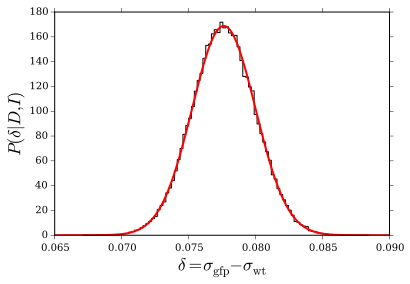

In [3]:
# Compute mean and standard deviation
delta_mean = (sampler.flatchain[:,1] - sampler.flatchain[:,0]).mean()
delta_std = (sampler.flatchain[:,1] - sampler.flatchain[:,0]).std()

# Generate Gaussian distribution to plot for fun
x = np.linspace(0.065, 0.090, 200)
y = np.exp(-(x - delta_mean)**2 / 2.0 / delta_std**2) / np.sqrt(2 * np.pi) \
        / delta_std

# Plot the histogram of mean differences
n, b, p = plt.hist(sampler.flatchain[:,1] - sampler.flatchain[:,0], 
                   bins=100, normed=True, histtype='step', color='k')
plt.plot(x, y, 'r-')

# Label axes
plt.xlabel(r'$\delta = \sigma_\mathrm{gfp} - \sigma_\mathrm{wt}$')
plt.ylabel(r'$P(\delta|D,I)$');

# Print result to screen
print(u'delta = %.4f += %.4f µm' % (delta_mean, delta_std))

<br />
<br />

### Problem 4.2 (Nonlinear regression in Spire-actin binding, 90 pts + 20 pts extra credit)

In this problem, we will explore many aspects of doing nonlinear regression.  You will learn about numerical optimization techniques to use when least squares is not appropriate and about using informative priors.  You will also learn, again, how important it is to do the work up front as you develop your model to best describe your data.

#### Regression when we can't do least squares

Before we begin, I will give a brief discussion on optimization techniques in the `scipy.optimize` module.  There are two main ways to do optimization using SciPy.  First, if the function to minimize is of the form

\begin{align}
\sum_i(g_i(\mathbf{a}))^2,
\end{align}

we use `scipy.optimize.leastsq`.  This is what we use when the problem of finding the maximal posterior reduces to minimizing the sum of the squares of the residuals, in which

\begin{align}
g_i(\mathbf{a}) = \frac{(y_i - f(x_i;\mathbf{a}))^2}{2\sigma_i},
\end{align}

where $f(x_i;\mathbf{a})$ is the mathematical model for the data.  Under the hood, `scipy.optimize.curve_fit` calls `scipy.optimize.leastsq`.  This uses the Levenberg-Marquardt algorithm, which is a powerful optimization algorithm.

If the function to optimize is not of this form, we cannot use the Levenberg-Marquardt algorithm to find the most probable parameter values.  We instead need to use other optimization techniques.  These are available through the `scipy.optimize.minimize` function.  As an example, consider performing a linear regression (with the function $f(x) = ax + b$) of a set of data where we use the noninformative prior

\begin{align}
P(a,b~|~I) \propto (1 + a^2)^{-\frac{3}{2}}.
\end{align}

In this case, assuming an unknown variance $\sigma$ describing the spread of the data,

\begin{align}
P(a,b,\sigma~|~D,I) \propto \frac{1}{\sigma^{n+1}(1+a^2)^{\frac{3}{2}}} 
\exp\left\{-\sum_{i\in D} \frac{(y_i - a - bx_i)^2}{2\sigma^2}\right\}.
\end{align}

We can no longer just ignore the value of $\sigma$, since it now has an effect on the most probable values of $a$ and $b$.  We therefore need to marginalize over $\sigma$ to find the most probable $a$ and $b$.  I will not go into the details of the marginalization here, but state the result.

\begin{align}
P(a,b~|~D,I) = \int_0^\infty \mathrm{d}\sigma \,P(a,b,\sigma~|~D,I)
\propto P(a,b~|~I)\,\left(\sum_{i\in D} (y_i - a - bx_i)^2\right)^{-\frac{n}{2}}.
\end{align}

Therefore, our log posterior is

\begin{align}
\ln P(a,b~|~D,I) = \text{constant} - \frac{3}{2}\ln(1+a^2) - \frac{n}{2}\ln\left(\sum_{i\in D} (y_i - a - bx_i)^2\right).
\end{align}

This is no longer in the form needed for least squares.  We could then perform our curve fitting using `scipy.optimize.minimize`.  You can read the [its documentation](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.minimize.html) to see how to use it.  Importantly, it is called as `scipy.optimize.minimize(f, p0, args)`.  Here, `f` us the function to be optimized, and it must be of the form `f(p, *args)`, where `p` is a NumPy array of the parameters that are to be adjusted to find the minimal `f`.  The remaining arguments to the function are passed into `scipy.optimize.minimize` as a tuple named `args`.  Finally, `p0` is an array of the guesses for optimal values of the parameters.

I will now demonstrate how to use `scipy.optimize.minimize` to perform a linear regression on fake data.

Best fit a = 1.90459, best fit b = 3.24027


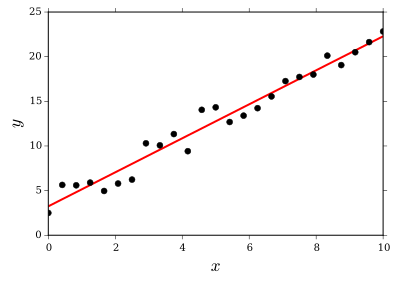

In [2]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Generate fake data
np.random.seed(42)
a_actual = 2.0
b_actual = 3.0
x = np.linspace(0.0, 10.0, 25)
y = a_actual * x + b_actual
y += np.random.uniform(-2.0, 2.0, len(x))

# Define my fit function
def linear_fit_fun(p, x):
    a, b = p
    return a * x + b

# Define function to minimize (-log posterior)
def neg_log_posterior(p, x, y):
    a, b = p
    n = len(x)
    return 1.5 * np.log(1.0 + a**2) \
                + n / 2.0 * np.log(((y - a * x - b)**2).sum())
    
# Generate guess of parameter values
p0 = np.array([1.0, 1.0])

# Use scipy.optimize.minimize to compute minumum
opt_result = scipy.optimize.minimize(neg_log_posterior, p0, (x, y))

# Results are stored in an OptimizeResult object.  opt_result.x is optimal
# parameter values
if opt_result.success:
    popt = opt_result.x
else:
    print('Optimization failed with message: %s' % opt_result.message)
    
# With our new good result, make plot
a, b = popt
plt.plot(x, y, 'ko', zorder=1)
plt.plot(x, a * x + b, 'r-', zorder=0)
plt.xlabel('$x$')
plt.ylabel('$y$');

# Print result to screen
print('Best fit a = %g, best fit b = %g' % (a, b))

Once we find the optimal parameters, we can do our usual method of computing error bars.

#### Background on the data set and analysis of binding

The data set we will consider in this problem comes from a [recent paper by Rasson and coworkers](http://www.sciencedirect.com/science/article/pii/S0022283614004720#) in Margot Quinlan's lab at UCLA.  You can download the data set [here](http://bebi103.caltech.edu/2014/protected/data/rasson_et_al.zip).

The authors were investigating the biochemistry of Spire-actin interactions.  Spire is an actin binding protein that can nucleate actin filaments.  In particular, it has four domains (called $S_A$, $S_B$, $S_C$, and $S_D$), which bind monomeric actin.  These four domains, acting in concert, can line up actin monomers to help in nucleation.  In this problem, we will determine the dissociation constant, $K_d$, describing binding of $S_D$ to monomeric actin.

The strategy to determine $K_d$ is to perform a titration experiment and then use nonlinear regression to determine $K_d$.  Consider the chemical reaction describing $S_D$-actin binding.

\begin{align}
\text{actin}\cdot S_D \rightleftharpoons \text{actin} + S_D,
\end{align}

which has dissociation constant $K_d$.  Let $c_a$ be the equilibrium concentation of actin and $c_d$ be the equilibrium concentration of $S_D$, and $c_{ad}$ be the equilibrium concentration of bound actin-$S_D$. Then, at equilibrium,

\begin{align}
K_d = \frac{c_a c_d}{c_{ad}}.
\end{align}


Now, if we start with a total actin concentration of $c_a^0$ and a total $S_D$ concentration of $c_d^0$, we also have

\begin{align}
c_a^0 = c_a + c_{ad}, \\[1mm]
c_d^0 = c_d + c_{ad},
\end{align}

by conservation of mass.

With these relations, we can now write $c_{ad}$ in terms of $c_a^0$ and $c_d^0$, which are known quantities (this is what we pippetted into our solution).

\begin{align}
K_d &= \frac{(c_a^0 - c_{ad})(c_d^0 - c_{ad})}{c_{ad}},\\[1mm]
\Rightarrow\;&\;\;c_{ad}^2 - (K_d + c_a^0 + c_d^0)c_{ad} + c_a^0 c_d^0 = 0.
\end{align}

The solution to this quadratic equation gives $c_{ad}$ as a function of $K_d$.  Note that we must choose one of the two roots, the one that is physical.  The physical root satisfies $0 < c_{ad} < \min(c_a^0, c_d^0)$.  In this case, it is

\begin{align}
c_{ad} = \frac{1}{2}\left(K_d + c_a^0 + c_d^0 - \sqrt{\left(K_d + c_a^0 + c_d^0\right)^2 - 4c_a^0c_d^0}\right).
\end{align}

We can write a function to compute $c_{ad}$ for a given $K_d$, $c_a^0$, and $c_d^0$.  Though we know the solution using the quadratic formula, we will use `np.roots` to do the calculation.

In [3]:
# Function to compute c_ad for dissociation reactions
def c_ad_diss(K_d, c_a_0, c_d_0):
    """
    Compute concentration of actin-S_D for a given value of c_a_0 and c_d_0.
    """
    poly_coeffs = np.array([1.0, 
                            -(K_d + c_a_0 + c_d_0), 
                            c_a_0 * c_d_0])
    
    # Use np.roots to solve for c_ad
    return np.roots(poly_coeffs).min()

So, since we know $c_a^0$ and $c_d^0$, if we can measure $c_{ad}$, we can compute $K_d$.  In a titration experiment, we fix $c_d^0$ and vary $c_a^0$, and measure $c_{ad}$ to get a curve.  From the curve, we can perform a regression to get $K_d$.  Example curves are shown below.

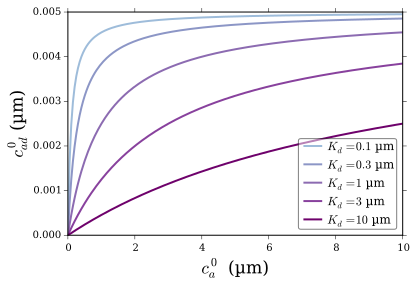

In [4]:
from brewer2mpl import sequential

# Values of K_d to consider, units of micromolar (uM)
K_d = [0.1, 0.3, 1.0, 3.0, 10.0]

# Fixed S_D concentration, units of micromolar (uM)
c_d_0 = 0.005

# Varied actin concentration for plotting (uM)
c_a_0 = np.linspace(0.0, 10.0, 200)

# Get a list of nice ColorBrewer colors
# (I don't like to use lightest colors, hence choosing 7 instead of 5)
bmap = sequential.BuPu[len(K_d) + 2]

# Make curves and plot
for i in range(len(K_d)):
    # Compute c_ad over the values of c_a_0.
    c_ad = np.empty_like(c_a_0)
    for j in range(len(c_a_0)):
        c_ad[j] = c_ad_diss(K_d[i], c_a_0[j], c_d_0)

    # Make plot
    label = u'$K_d = %g$ µm' % K_d[i]
    plt.plot(c_a_0, c_ad, '-', color=bmap.mpl_colors[i+2], label=label)
    plt.xlabel(u'$c_a^0$ (µm)')
    plt.ylabel(u'$c_{ad}^0$ (µm)')
    plt.legend(loc='lower right', framealpha=0.5)

The problem with this approach is that we do not have a direct way of measuring $c_{ad}$.  The authors instead employed [fluorescence anisotropy](http://en.wikipedia.org/wiki/Fluorescence_anisotropy).  I will not go into the details here of how it works, but will simply say that larger complexes rotate more slowly, and therefore give a higher fluorescence anisotropy signal (which is dimensionless) than do smaller complexes.

So, the authors fluorescently tagged $S_D$.  We will call this molecule $S_{D^*}$, with concentration $c_{d^*}$.  When free in solution, this molecule gives an anisotropy signal of $r_f$.  When bound to actin, it gives an anisotropy signal of $r_b$.  So, the total anisotropy signal we could detect is

\begin{align}
r = \frac{1}{c_{d^*}^0}\,\left(r_f c_{d^*} + r_b c_{ad^*}\right).
\end{align}

Clearly, when all $S_{D^*}$ is free, the anisotropy signal is $r_f$ and when all $S_{D^*}$ is bound to actin, the signal is $r_b$.  Remembering our conservation of mass, $c_{d^*} = c_{d^*}^0 - c_{ad^*}$, we have

\begin{align}
r = \frac{1}{c_{d^*}^0}\,\left(r_f (c_{d^*}^0 - c_{ad^*}) + r_b c_{ad^*}\right)
= r_f  + \frac{r_b-r_f}{c_{d^*}^0}\, c_{ad^*}.
\end{align}

Now, returning to our equilibrium expression, we have

\begin{align}
c_{ad^*} = \frac{1}{2}\left(K_d^* + c_a^0 + c_{d^*}^0 - \sqrt{\left(K_d^* + c_a^0 + c_{d^*}^0\right)^2 - 4c_a^0c_{d^*}^0}\right),
\end{align}

so we can write the measured anisotropy $r$ as a function of $K_d^*$ and the known quantitites $c_a^0$ and $c_{d^*}^0$.  Note that we now have three parameters for our regression, $K_d^*$, $r_f$, and $r_b$, since the latter two are not known *a priori*.

This is all fine and good, but if we do this regression, we are measuring the dissociation constant of $S_{D^*}$, **not** $S_D$.  To get $K_d$, we can use the fact that we know $K_d^*$ from dissociation experiments described above.  Now, say we add monomeric actin, $S_{D^*}$, **and** $S_D$ to a reaction mixture.  Then, we have two reactions going on.

\begin{align}
\text{actin-}S_D &\rightleftharpoons \text{actin} + S_D \\[1mm]
\text{actin-}S_{D^*} &\rightleftharpoons \text{actin} + S_{D^*},
\end{align}

with equilibrium constants $K_d$ and $K_d^*$, respectively.  In this case, we have five equations describing equilibium, the two equilibrium expressions and three conservation of mass expressions.

\begin{align}
K_d &= \frac{c_a c_d}{c_{ad}} \\[1mm]
K_d^* &= \frac{c_a c_{d^*}}{c_{ad^*}} \\[1mm]
c_a^0 &= c_a + c_{ad} + c_{ad^*}\\[1mm]
c_d^0 &= c_d + c_{ad} \\[1mm]
c_{d^*}^0 &= c_{d^*} + c_{ad^*}.
\end{align}

These five equations can be rearranged to give

\begin{align}
c_a^3 + \beta c_a^2 + \gamma c_a + \delta = 0,
\end{align}

with

\begin{align}
\beta &= K_d + K_d^* + c_d^0 + c_{d^*}^0 - c_a^0, \\[1mm]
\gamma &= K_d(c_{d^*}^0 - c_a^0) + K_d^*(c_d^0 - c_a^0) + K_d K_d^* \\[1mm]
\delta &= -K_d K_d^* c_a^0.
\end{align}

So, we can solve this third order polynomial for $c_a$.  We can then compute $c_{d^*}$ and $c_{ad^*}$ using the equilibrium and mass conservation relations for $S_{D^*}$ as

\begin{align}
c_{d^*} &= \frac{K_d^* c_{d^*}^0}{K_d^* + c_a} \\[1mm]
c_{ad^*} &= \frac{c_a c_{d^*}^0}{K_d^* + c_a}.
\end{align}

Given these expressions for $c_{ad^*}$ and $c_{d^*}$, we can compute the anistropy as a function of $K_d$, $K_d^*$, and the known quantities $c_a^0$, $c_d^0$, and $c_{d^*}^0$.

This looks like a complicated function for the anisotropy.  This is why researchers have consistently fit competition anisotropy data with approximate (wrong) functions.  In fact, the way most people have done this makes approximations that neglect the most dynamic part of the curve!  In practice, though, this is not a complicated function at all.  We can code it up in a few lines.  So, with a little thought and a little work, we can get a complete description of the titration curve.

In [5]:
# Returns anisotropy from competition experiment.
def comp_anis(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b):
    """
    Returns anisotropy measured from competition experiment.
    """
    # Define coeffiencts for third order polynomial
    beta = K_d + K_d_star + c_d_0 + c_d_star_0 - c_a_0
    gamma = K_d * (c_d_star_0 - c_a_0) + K_d_star * (c_d_0 - c_a_0) \
                    + K_d * K_d_star
    delta = -K_d * K_d_star * c_a_0
    
    # Compute roots (one of them is concentration of free actin)
    poly_roots = np.roots(np.array([1.0, beta, gamma, delta]))

    # Get index of root that we want (real, between 0 and c_a_0_
    inds = (np.isreal(poly_roots)) & (0 < poly_roots) & (poly_roots < c_a_0)
    c_a = poly_roots[inds][0]

    # Compute c_d* and c_ad*
    c_ad_star = c_a * c_d_star_0 / (K_d_star + c_a)
    c_d_star = c_d_star_0 - c_ad_star
    
    # Compute anisotropy
    return (r_f * c_d_star + r_b * c_ad_star) / c_d_star_0

So, we now have a function in hand that we can use to fit competition anisotropy data.  The strategy is to first perform regressions on titrations containing only $S_D^*$ and monomeric actin to get a value for $K_{d^*}$.  Then, we will use this result fo perform a regression on the competition anisotropy titrations to get a value for $K_d$.

**a)** When performing a regression on a titration curve, the equilibrium constant should have a Jeffreys prior.  Explain why.

**b)** The file `rasson_dissociation_anisotropy.csv` contains two data sets for titrations where $c_{d^*}^0$ was held constant at 5 nM and monomeric actin was titrated.  For each $c_a^0$, the fluorescence anisotropy was measured.  For each of the two data sets, perform a regression to compute $K_d$ and its error bar.  *Hint*: Marginalize $\sigma$ and optimize the marginalized posterior.  The relation below, which is worked out in section 8.2 of Sivia, will help.

\begin{align}
\int_0^\infty \mathrm{d}\sigma \, \sigma^{-n-1}\,\exp\left\{\frac{1}{2\sigma^2}\sum_{i\in D} (y_i - f(x_i))^2\right\}
\propto \left(\sum_{i\in D} (y_i - f(x_i))^2\right)^{-\frac{n}{2}}
\end{align}

**c)** Treat the result of each regression as a "measurement" of $K_d^*$.  Given the two measurements, what values do we have for $K_d^*$ and its error bar?

**d)** The file `rasson_competition_anisotropy.csv` contains four data sets of competition anisotropy experiments.  The total concentration of monomeric actin was held constant at $c_a^0 = 2$ µM.  The total concentration of $S_{D^*}$ was held constant at $c_{d^*}^0 = 5$ nM.  The total concentration of $S_D$, $c_d^0$, was varied to give the titration curve.  Perform a regression for each experiment to find a value for $K_d$.  In part (c), you found a value and error bar for $K_{d^*}$.  Use these values for $K_d^*$ to approximate its prior as a Gaussian in the regression of the competition anisotropy experiments.

**e)** Do a similar analysis as in part (c) to compute a value and error bar for $K_d$.

**f)** (20 points extra credit)  Instead of doing each regression separately and then using (approximate) informative priors, perform a regression for all six experiments at once.  Assume that $K_d$ and $K_d^*$ is the same in each experiment, but assume that $r_f$ and $r_b$ are different for each trial.  Experimentally, $r_f$ and $r_b$ vary from experiment to experiment because of varying buffer conditions, wear and tear on the polarizers and fluorimeter, etc.  (These experiments were performed on different days.)  So, your posterior is

\begin{align}
P(K_d, K_d^*, \{r_f\}, \{r_b\}~|~\{D\}, I),
\end{align}

where $D_i$ is the data set from experiment $i$ and $\{r_b\}$ denotes the set of $r_b$'s for each experiment, $\{r_{b,1}, r_{b,2}, r_{b,3}, r_{b,4}, r_{b,5}, r_{b,6}\}$, with $\{D\}$ and $\{r_f\}$ similarly defined.  You can do the regression either by MCMC or by numerical optimization.

### Problem 4.2 solution

**a)** The equilibrium constant should have a Jeffreys prior because the direction of the chemical reaction we chose was arbitrary.  Instead of specifying a dissociation constant $K_d$, we could have chosen an *association* constant $K$.  So, there is a symmetry.  We want $P(K_d < 1~|~I) = P(K_d > 1~|~I)$, which naturally leads to a Jeffreys prior.

**b)** We assume that we do not know the variance in the measured data, but assume it is equal for all points and define this value to be $\sigma$.  We further assume that our mathematical/physical model for the anisotropy is correct (it's just mass action).  We assume that the data are Gaussian distributed with variance $\sigma$ about the value predicted by the mass action model.  Finally, we assume uniform priors for $r_f$ and $r_b$ and Jeffreys priors for $K_d$ and $\sigma$.  Then, our posterior is

\begin{align}
P(K_d, r_f, r_b,\sigma~|~D,I) \propto \frac{1}{K_d\,\sigma^{n+1}}\,\exp\left\{
\frac{1}{2\sigma^2}\sum_{i\in D}(r_i - r(c_{a,i}^0; K_d, r_f, r_b)\right\},
\end{align}

here $r(c_{a,i}^0; K_d, r_f, r_b)$ is the anisotropy predicted by the mass action model.  We compute a marginalized posterior by integrating over $\sigma$.  Using the result given in the problem statement, we have

\begin{align}
P(K_d, r_f, r_b~|~D,I) \propto \frac{1}{K_d}\,\left(\sum_{i\in D} \left(r_i - r(c_{a,i}^0; K_d, r_f, r_b)\right)^2\right)^{-\frac{n}{2}}.
\end{align}

Therefore, our log posterior is

\begin{align}
\ln P(K_d, r_f, r_b~|~D,I) = \text{constant} - \ln K_d - \frac{n}{2}\,\ln\left(
\sum_{i\in D} \left(r_i - r(c_{a,i}^0; K_d, r_f, r_b)\right)^2\right).
\end{align}

This is the function we wish to maximize.  To do so, we minimize $-\ln P(K_d, r_f, r_b~|~D,I)$ with respect to $K_d$, $r_f$, and $r_b$.  We will use `scipy.optimize.minimize` to perform the optimization.

Before we do that, let's load and plot the data to help us get good guesses for the parameter values.  First, load the data and take a look.

In [6]:
df = pd.read_csv('../data/rasson_et_al/rasson_dissociation_anisotropy.csv',
                 comment='#')
df.head()

,[SDfluor] (uM),[actin] (uM) trial 1,anisotropy trial 1,[actin] (uM) trial 2,anisotropy trial 2
0,0.005,31.10,115.2,16,126.3
1,NaN,16.55,114.0,8,128.4
2,NaN,8.28,113.9,4,126.4
3,NaN,4.14,112.7,2,122.4
4,NaN,2.07,109.0,1,119.7


Let's rename the columns, and pull out the value of $c_{d^*}^0$.

In [7]:
# Rename columns
df.columns = ['c_d_star_0', 'c_a_0_diss_1', 'r_diss_1', 
              'c_a_0_diss_2', 'r_diss_2']

# Get c_d_star_0
c_d_star_0 = df.c_d_star_0.iloc[0]

# Since we will be indexing them in function calls, store as NumPy arrays
c_a_0_diss_1 = df.c_a_0_diss_1
r_diss_1 = df.r_diss_1
c_a_0_diss_2 = df.c_a_0_diss_2
r_diss_2 = df.r_diss_2

And now, we'll make plots.

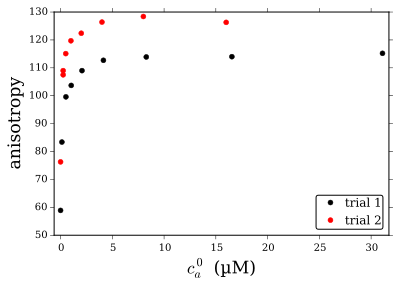

In [8]:
# Plot data points
plt.plot(c_a_0_diss_1, r_diss_1, 'k.', ms=10, label='trial 1')
plt.plot(c_a_0_diss_2, r_diss_2, 'r.', ms=10, label='trial 2')
plt.margins(x=0.02)
plt.xlabel(u'$c_a^0$ (µM)')
plt.ylabel('anisotropy')
plt.legend(loc='lower right', numpoints=1)

We see immediately that, as described in the problem statement, $r_f$ and $r_b$ may vary from experiment to experiment.  But, we will give a ballpark guess of $r_f = 60$ and $r_b = 120$.  The curves more or less reach their plateau at $c_a^0 = 5$ µM.  Looking at the curves in the problem statement, we guess that $K_d^*$ is approximately 0.5 µM.

In [9]:
# For convenience, it's nice to be able to pass an array into c_ad_diss,
# so we'll make a convenience function for that.
def c_ad_diss_array(K_d_star, c_a_0, c_d_star_0):
    """
    Computes c_ad for a dissociation reaction for a single value of K_d and
    c_d_0, but for an array c_a_0.
    """
    c_ad_star = np.empty_like(c_a_0)
    
    for i in range(len(c_a_0)):
        c_ad_star[i] = c_ad_diss(K_d_star, c_a_0[i], c_d_star_0)
        
    return c_ad_star

# It is also convenient to have a function to give the anisotropy
def r_diss_array(K_d_star, c_a_0, c_d_star_0, r_f, r_b):
    """
    Gives anisotropy for a dissociation reaction.
    """
    return r_f + (r_b - r_f) / c_d_star_0 \
                        * c_ad_diss_array(K_d_star, c_a_0, c_d_star_0)
    
# Define log of the posterior
def log_post_diss(p, c_a_0, r, c_d_star_0):
    """
    Log of the posterior with
    p[0] = K_d_star
    p[1] = r_f
    p[2] = r_b
    """
    # Check to make sure in range of priors
    if (p <= 0.0).any():
        return -np.inf

    # Unpack parameters
    K_d_star, r_f, r_b = p

    # Number of data points
    n = len(c_a_0)
    
    # Compute theoretical curve
    r_theor = r_diss_array(K_d_star, c_a_0, c_d_star_0, r_f, r_b)
    
    return -np.log(K_d_star) - n / 2.0 * np.log(((r - r_theor)**2).sum())

# Objective function for minimize solver
def neg_log_post_diss(p, c_a_0, r, c_d_star_0):
    return -log_post_diss(p, c_a_0, r, c_d_star_0)
        
# Initial guess at parameters
K_d_star_0 = 0.5   # microMolar
r_f_0 = 60.0
r_b_0 = 120.0
p0 = np.array([K_d_star_0, r_f_0, r_b_0])

# Perform the curve fits (use Powell's method because BFGS doesn't like
# infinite values returned by function because it computes gradients)
args = (c_a_0_diss_1, r_diss_1, c_d_star_0)
opt_result = scipy.optimize.minimize(neg_log_post_diss, p0, args,
                                     method='Powell')
if opt_result.success:
    popt_diss_1 = opt_result.x
else:
    print('Optimization failed with message: %s' % opt_result.message)
    raise RuntimeError('Optimization failed!')
    
# Do the same for trial 2
args = (c_a_0_diss_2, r_diss_2, c_d_star_0)
opt_result = scipy.optimize.minimize(neg_log_post_diss, p0, args,
                                     method='Powell')
if opt_result.success:
    popt_diss_2 = opt_result.x
else:
    print('Optimization failed with message: %s' % opt_result.message)
    raise RuntimeError('Optimization failed!')

Now that we have our optimal parameters; let's compute the error bars.  Just as we've learned in class, we numerically compute the Hessian of the log posterior at the most probable parameter values.

In [10]:
# Compute covariance matrix for both trials
cov_diss_1 = np.linalg.inv(jb.hess_nd(neg_log_post_diss, popt_diss_1, 
                                      (c_a_0_diss_1, r_diss_1, c_d_star_0)))
cov_diss_2 = np.linalg.inv(jb.hess_nd(neg_log_post_diss, popt_diss_2, 
                                      (c_a_0_diss_2, r_diss_2, c_d_star_0)))

# Compute error bars
err_diss_1 = np.sqrt(np.diag(cov_diss_1))
err_diss_2 = np.sqrt(np.diag(cov_diss_2))

With these in hand, we can print our results to the screen.

In [11]:
# Print most probable K_d, r_f, and r_b with error bars.
formats = tuple(popt_diss_1) + tuple(err_diss_1)
print("""
Dissociation Trial 1
====================
K_d* = {0:.4f} +- {3:.4f} µM 
r_f  = {1:.2f}  +- {4:.2f}
r_b  = {2:.2f} +- {5:.2f}
""".format(*formats))

formats = tuple(popt_diss_2) + tuple(err_diss_2)
print("""
Dissociation Trial 2
====================
K_d* = {0:.4f} +- {3:.4f} µM 
r_f  = {1:.2f}  +- {4:.2f}
r_b  = {2:.2f} +- {5:.2f}
""".format(*formats))


Dissociation Trial 1
K_d* = 0.1836 +- 0.0160 µM 
r_f  = 59.34  +- 1.11
r_b  = 114.43 +- 0.56


Dissociation Trial 2
K_d* = 0.1538 +- 0.0114 µM 
r_f  = 76.35  +- 1.01
r_b  = 127.50 +- 0.56



Finally, let's generate smooth curves and see how our regressions look.

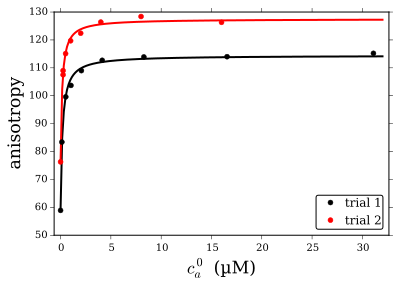

In [12]:
# Generate smooth curves
c_a_0_smooth = np.linspace(0.0, 32.0, 200)
K_d_star, r_f, r_b = popt_diss_1
r_theor_diss_1 = r_diss_array(K_d_star, c_a_0_smooth, c_d_star_0, r_f, r_b)

K_d_star, r_f, r_b = popt_diss_2
r_theor_diss_2 = r_diss_array(K_d_star, c_a_0_smooth, c_d_star_0, r_f, r_b)


# Plot curves with data
plt.plot(c_a_0_diss_1, r_diss_1, 'k.', ms=10, label='trial 1', zorder=1)
plt.plot(c_a_0_diss_2, r_diss_2, 'r.', ms=10, label='trial 2', zorder=1)
plt.plot(c_a_0_smooth, r_theor_diss_1, 'k-', zorder=0)
plt.plot(c_a_0_smooth, r_theor_diss_2, 'r-', zorder=0)
plt.margins(x=0.02)
plt.xlabel(u'$c_a^0$ (µM)')
plt.ylabel('anisotropy')
plt.legend(loc='lower right', numpoints=1)

We pause to note here that when possible when doing numerical integration, it is wise to change variables such that you can do an unconstrained optimization versus a constrained optimization.  Our optimization problem is contrained because $K_d^*$, $r_f$, and $r_b$ can only take on positive values.  It is also wise to use the Levenberg-Marquardt algorithm because it is quite robust.  In practice, the positivity constraing on $K_d$ is more bothersome because $K_d$ is closer to zero.  More importantly, the Jeffreys prior of $K_d$ precludes use of the L-M algorithm because the objective function is no longer a sum of squares.

There is a clever way around this.  Note that if we instead chose the free energy of binding, $G/kT$ as our parameter, we would use a uniform prior.  This can be shown as follows.

\begin{align}
K_d = \rho_\mathrm{solv}\,\mathrm{e}^{-G/kT},
\end{align}

where $\rho_\mathrm{solv}$ is the molarity of the solvent.  If we choose a uniform prior for $G/kT$, we can do a change of variables.

\begin{align}
P(G/kT) &= P(K_d)\,\left|\frac{\mathrm{d}K_d}{\mathrm{d}(G/kT)}\right|
= P(K_d)K_d = \text{constant} \\[1mm]
\Rightarrow \; P(K_d) &= \frac{\text{constant}}{K_d},
\end{align}

a Jeffreys prior.  So, a uniform prior in the free energy is equivalent to a Jeffreys prior in the dissociation constant.  So, is we now make the free energy, $G/kT$ our parameter, the log marginalized posterior is

\begin{align}
\ln P(K_d, r_f, r_b~|~D,I) = \text{constant} - \frac{n}{2}\,\ln\left(
\sum_{i\in D} \left(r_i - r(c_{a,i}^0; G/kT, r_f, r_b)\right)^2\right).
\end{align}

Note now that maximizing this function is equivalent to minimizing

\begin{align}
\sum_{i\in D} \left(r_i - r(c_{a,i}^0; G/kT, r_f, r_b)\right)^2,
\end{align}

so we can again use least squares.  Instead of using `scipy.optimize.curve_fit`, we will directly use `scipy.optimize.leastsq`.

In [13]:
# Define array that will be squared in to make objective function
def resids_diss(p, c_a_0, r, c_d_star_0):
    """
    Residuals of the data compared to mass action model.
    p[0] = -log(K_d_star)
    p[1] = r_f
    p[2] = r_b
    """
    G, r_f, r_b = p
    K_d_star = np.exp(-G)
    return r - r_diss_array(K_d_star, c_a_0, c_d_star_0, r_f, r_b)

# Initial guess
G_0 = -np.log(0.5)
r_f_0 = 60.0
r_b_0 = 120.0
p0 = np.array([G_0, r_f_0, r_b_0])

# Perform curve fits using scipy.optimize.leastsq
args = (c_a_0_diss_1, r_diss_1, c_d_star_0)
popt_diss_1_lstq, junk_output = scipy.optimize.leastsq(
                                    resids_diss, p0, args=args)

args = (c_a_0_diss_2, r_diss_2, c_d_star_0)
popt_diss_2_lstq, junk_output = scipy.optimize.leastsq(
                                    resids_diss, p0, args=args)

# Let's compare results, and also check optimality
formats = tuple(popt_diss_1) \
        + (log_post_diss(popt_diss_1, c_a_0_diss_1, r_diss_1, c_d_star_0),)
print("""
Trial 1 minimize
================
K_d* = {0:g} µM 
r_f  = {1:g}
r_b  = {2:g}
log posterior = {3:g}
 """.format(*formats))

K_d_star = np.exp(-popt_diss_1_lstq[0])
popt = np.array([K_d_star, popt_diss_1_lstq[1], popt_diss_1_lstq[2]])
formats = (K_d_star, popt_diss_1_lstq[1], popt_diss_1_lstq[2],
           log_post_diss(popt, c_a_0_diss_1, r_diss_1, c_d_star_0))
print("""
Trial 1 leastsq
===============
K_d* = {0:g} µM
r_f  = {1:g}
r_b  = {2:g}
log posterior = {3:g}
""".format(*formats))

formats = tuple(popt_diss_2) \
        + (log_post_diss(popt_diss_2, c_a_0_diss_2, r_diss_2, c_d_star_0),)
print("""
Trial 2 minimize
================
K_d* = {0:g} µM 
r_f  = {1:g}
r_b  = {2:g}
log posterior = {3:g}
""".format(*formats))

K_d_star = np.exp(-popt_diss_2_lstq[0])
popt = np.array([K_d_star, popt_diss_2_lstq[1], popt_diss_2_lstq[2]])
formats = (K_d_star, popt_diss_2_lstq[1], popt_diss_2_lstq[2],
           log_post_diss(popt, c_a_0_diss_2, r_diss_2, c_d_star_0))
print("""
Trial 2 leastsq
===============
K_d* = {0:g} µM
r_f  = {1:g}
r_b  = {2:g}
log posterior = {3:g}
""".format(*formats))




Trial 1 minimize
K_d* = 0.183556 µM 
r_f  = 59.3354
r_b  = 114.434
log posterior = -9.16707
 

Trial 1 leastsq
K_d* = 0.184957 µM
r_f  = 59.3856
r_b  = 114.462
log posterior = -9.17085


Trial 2 minimize
K_d* = 0.153846 µM 
r_f  = 76.3545
r_b  = 127.496
log posterior = -8.0726


Trial 2 leastsq
K_d* = 0.154691 µM
r_f  = 76.3883
r_b  = 127.522
log posterior = -8.07531



Both methods give close to the same log posterior, with the minimization method performing slightly better.  The performance could be tuned by adjusting tolerances in the minimization schemes of the respective algorithms (see the [`scipy.optimize` documentation](http://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html)).

A final method we could use is MCMC.  We could perform MCMC using the marginalized posterior, but since MCMC is easy, we might as well also learn something about the unknown variance in the data, $\sigma$.  We can also do both regressions at once.  Remember, $r_f$ and $r_b$ differ from experiment to experiment, but $K_d^*$ and $K_d$ presumably do not.  So, we consider a seven parameter model, $K_d^*$, $r_{f,1}$, $r_{f,2}$, $r_{b,1}$, $r_{b,2}$, $\sigma_1$, $\sigma_2$, where the last two parameters describe the spread in the data for each of the two dissociation experiments.  So, our log posterior is

\begin{align}
&\ln P(K_d^*, r_{f,1}, r_{f,2}, r_{b,1}, r_{b,2}, \sigma_1, \sigma_2~|~D_1, D_2,I) \\[1mm]
&\;\;\;\;=\text{constant} - \ln K_d^* - (n_1 + 1) \ln \sigma_1 - (n_2 + 1) \ln \sigma_2 \\[1mm]
&\;\;\;\;\;\;\;\;- \frac{1}{2\sigma_1}\sum_{i \in D_1} \left(r_i - r(c_{a,1}^0; K_d^*, r_{f,1},r_{b,1})\right)^2 \\[1mm]
&\;\;\;\;\;\;\;\;- \frac{1}{2\sigma_2}\sum_{i \in D_2} \left(r_i - r(c_{a,2}^0; K_d^*, r_{f,2},r_{b,2})\right)^2.
\end{align}

So, let's just do it!

In [14]:
# Define log posterior
def log_post_with_sigma(p, c_a_0, r, c_d_star_0):
    """
    Log of the posterior with
    p[0] = K_d_star
    p[1] = r_f_1
    p[2] = r_f_2
    p[3] = r_b_1
    p[4] = r_b_2
    p[5] = sigma_1
    p[6] = sigma_2
    
    c_a_0[0] = NumPy array of c_a_0 values for trial 1
    c_a_0[1] = NumPy array of c_a_0 values for trial 2
    r[0] and r[1] similarly defined.
    c_d_star_0 is the concentration of fluorescently labeled S_D.
    """
    # Check to make sure in range of priors
    if (p <= 0.0).any():
        return -np.inf

    # Unpack parameters
    K_d_star, r_f_1, r_f_2, r_b_1, r_b_2, sigma_1, sigma_2 = p

    # Number of data points
    n_1 = len(c_a_0[0])
    n_2 = len(c_a_0[1])
    
    # Compute theoretical curves
    r_theor_1 = r_diss_array(K_d_star, c_a_0[0], c_d_star_0, r_f_1, r_b_1)
    r_theor_2 = r_diss_array(K_d_star, c_a_0[1], c_d_star_0, r_f_2, r_b_2)
    
    # Compute log of posterior
    return -np.log(K_d_star) - (n_1 + 1) * np.log(sigma_1) \
                - (n_2 + 1) * np.log(sigma_2) \
                - ((r[0] - r_theor_1)**2).sum() / (2.0 * sigma_1**2) \
                - ((r[1] - r_theor_2)**2).sum() / (2.0 * sigma_2**2)


# MCMC parameters
n_dim = 7        # 4 parameters, K_d_star, r_f, r_b, sigma
n_walkers = 50   # number of MCMC walkers
n_burn = 500    # "burn-in" period to let chains stabilize
n_steps = 5000 # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# We'll randomize in a Gaussian fashion about our guesses.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.lognormal(np.log(0.3), 0.3, n_walkers) # K_d_star
p0[:,1] = np.random.normal(60.0, 5.0, n_walkers)           # r_f_1
p0[:,2] = np.random.normal(60.0, 5.0, n_walkers)           # r_f_2
p0[:,3] = np.random.normal(120.0, 5.0, n_walkers)          # r_b_1
p0[:,4] = np.random.normal(120.0, 5.0, n_walkers)          # r_b_2
p0[:,5] = np.random.exponential(1.0, n_walkers)            # sigma_1
p0[:,6] = np.random.exponential(1.0, n_walkers)            # sigma_2


# Set up the EnsembleSampler instance
sampler_diss = emcee.EnsembleSampler(
    n_walkers, n_dim, log_post_with_sigma, 
    args=([c_a_0_diss_1, c_a_0_diss_2], [r_diss_1, r_diss_2], c_d_star_0))

# Do the burn-in
pos, prob, state = sampler_diss.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler_diss.reset()
pos, prob, state = sampler_diss.run_mcmc(pos, n_steps)

Now that we have done our MCMC calculation, we can find the most probable $K_d^*$ and also plot its distribution.

most probable K_d* = 0.1695


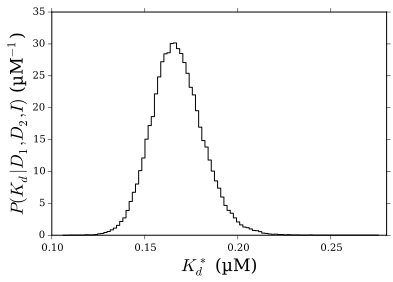

In [15]:
# Compute most probable K_d_star
max_ind = np.argmax(sampler_diss.flatlnprobability)
p_mp = sampler_diss.flatchain[max_ind,:]

# Print it to the screen
print('most probable K_d* = %.4f' % p_mp[0])

# Plot a probability distribution of K_d_star values
n, b, p = plt.hist(sampler_diss.flatchain[:,0], 
                   bins=100, normed=True, histtype='step', color='k')
plt.xlabel(u'$K_d^*$ (µM)')
plt.ylabel(u'$P(K_d|D_1,D_2,I)$ (µM$^{-1}$)')

**c)** We treat each regression as an "experiment" in which we measured $K_d^*$.  Then, we have two measurements, each of which carries an error.  So, the posterior distribution is

\begin{align}
P(K_d^*~|~K_{d,1}^*, K_{d,2}^*, \sigma_1, \sigma_2, I) &\propto \frac{1}{K_d^*}\,
\frac{1}{\sigma_1}\exp\left\{-\frac{(K_d^* - K^*_{d,1})^2}{2\sigma_1^2}\right\}\\[1mm]
&\;\;\;\;\times \frac{1}{\sigma_2}\exp\left\{-\frac{(K_d^* - K^*_{d,2})^2}{2\sigma_2^2}\right\}
\end{align}

The log posterior is then

\begin{align}
\ln P(K_d^*~|~K_{d,1}^*, K_{d,2}^*, \sigma_1, \sigma_2, I) = \text{constant}
- \frac{1}{2\sigma_1^2}(K_d^* - K^*_{d,1})^2
- \frac{1}{2\sigma_2^2}(K_d^* - K^*_{d,2})^2.
\end{align}

We can find when this is maximal by differentiating.

\begin{align}
\frac{\mathrm{d}}{\mathrm{d}K_d^*}\,\ln P(K_d^*~|~K_{d,1}^*, K_{d,2}^*, \sigma_1, \sigma_2, I) &= 
- \frac{K_d^* - K^*_{d,1}}{\sigma_1^2}
- \frac{K_d^* - K^*_{d,2}}{\sigma_2^2} \\[1mm]
&= -K_d^*\left(\sigma_1^{-2} + \sigma_2^{-2}\right) 
+ \frac{K^*_{d,1}}{\sigma_1^2} + \frac{K^*_{d,2}}{\sigma_2^2} = 0
\end{align}

Therefore, we get our most probable value of $K_d^*$ to be

\begin{align}
\text{most prob. } K_d^* = \left(\frac{K_{d,1}^*}{\sigma_1^2} + \frac{K_{d,2}^*}{\sigma_2^2}\right)\frac{1}{\sigma_1^{-2} + \sigma_2^{-2}}.
\end{align}

We can compute the second derivative to get the error bar.

\begin{align}
\frac{\mathrm{d}^2}{\mathrm{d}(K_d^*)^2}\,\ln P(K_d^*~|~K_{d,1}^*, K_{d,2}^*, \sigma_1, \sigma_2, I) &= 
- \frac{1}{\sigma_1^2}
- \frac{1}{\sigma_2^2}
\end{align}

Thus, the variance is

\begin{align}
\sigma_{K_d^*}^2 = \left(\sigma_1^{-2} + \sigma_2^{-2}\right)^{-1}.
\end{align}

These results are in fact general.  If one does $n$ measurements $\{x_i\}$, with error bars $\{\sigma_i\}$, the value of $x$ is Gaussian distributed with the most probable $x$ being

\begin{align}
\frac{1}{\sum_i \sigma_i^{-2}}\sum_i\frac{x_i}{\sigma_i^2}
\end{align}

and the variance being

\begin{align}
\sigma_x^2 = \frac{1}{\sum_i \sigma_i^{-2}}.
\end{align}

We apply this formula to get a value for $K_d^*$ and its error bar.

In [16]:
# Compute K_d_star from our two regressions
K_d_star_diss = (popt_diss_1[0] / err_diss_1[0]**2 
            + popt_diss_2[0] / err_diss_2[0]**2) \
            / (1.0 / err_diss_1[0]**2 + 1.0 / err_diss_2[0]**2)

# Compute the error bar
K_d_star_diss_err = 1.0 / np.sqrt(1.0 / err_diss_1[0]**2 
                                  + 1.0 / err_diss_2[0]**2)
    
# Print the result to the screen
print(r'K_d_star = %.4f +- %.4f µM' % (K_d_star_diss, K_d_star_diss_err))

K_d_star = 0.1638 +- 0.0093 µM


To get a comparison, let's plot the distibution we just calculated by doing two curve fits and making Gaussian approximations with the result from MCMC.

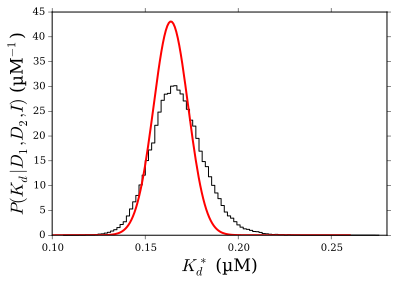

In [17]:
# Make smooth Gausian curve
x = np.linspace(0.10, 0.26, 200)
y = np.exp(-(x - K_d_star_diss)**2 / 2.0 / K_d_star_diss_err**2) \
     / np.sqrt(2.0 * np.pi) / K_d_star_diss_err

# Plot a probability distribution of K_d_star values
n, b, p = plt.hist(sampler_diss.flatchain[:,0], 
                   bins=100, normed=True, histtype='step', color='k')
plt.plot(x, y, 'r-')
plt.xlabel(u'$K_d^*$ (µM)')
plt.ylabel(u'$P(K_d|D_1,D_2,I)$ (µM$^{-1}$)');

We see that the true posterior has longer tails than the Gaussian approximation.  This is even more apparent when viewed on a log scale.

(1e-08, 100.0)

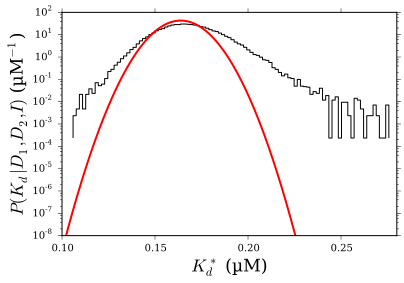

In [18]:
# Plot a probability distribution of K_d_star values
n, b, p = plt.hist(sampler_diss.flatchain[:,0], log=True,
                   bins=100, normed=True, histtype='step', color='k')
plt.semilogy(x, y, 'r-')
plt.xlabel(u'$K_d^*$ (µM)')
plt.ylabel(u'$P(K_d|D_1,D_2,I)$ (µM$^{-1}$)');
plt.ylim((1e-8, 1e2))

**d)** To perform the regression of the competition data, we use our previous results for $K_d^*$ as a prior.  I.e.,

\begin{align}
P(K_d^*~|~I) = \frac{1}{\sqrt{2\pi\sigma_{K_d^*}^2}}\,\exp\left\{
-\frac{(K_d^*-\mu_{K_d^*})^2}{2\sigma_{K_d^*}^2}\right\},
\end{align}

where $\mu_{K_d^*}$ is the value of $K_d^*$ we got from our dissociation experiments in part (c).  Thus, our posterior (with the unknown spread in the data, $\sigma$, marginalized) for a competition regression is

\begin{align}
P(K_d,K_d^*, r_f, r_b~|~D,I) &\propto \frac{1}{K_d}\exp\left\{
-\frac{(K_d^*-\mu_{K_d^*})^2}{2\sigma_{K_d^*}^2}\right\}\\[1mm]
&\;\;\;\times \left(
\sum_{i\in D}\left(r_i - r(x_i;K_d, K_d^*, c_a^0, c_{d,i}^0, r_f, r_b)\right)^2
\right)^{\frac{n}{2}}.
\end{align}

As we code up the posterior, it is convenient to first have a function that can take $c_d^0$ as an array and return an array of anisotropy values.

In [19]:
# For convenience, it's nice to be able to pass an array into comp_anis,
# so we'll make a convenience function for that.
def r_comp_array(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b):
    """
    Computes r for competition anisotropy system for a single value of K_d,
    K_d_star, c_a_0, but for an array of c_d_0.
    """
    r = np.empty_like(c_d_0)
    
    for i in range(len(c_d_0)):
        r[i] = comp_anis(K_d, K_d_star, c_a_0, c_d_0[i], c_d_star_0, 
                         r_f, r_b)

    return r

We can now write a function for the log posterior.

In [20]:
# Define log of the posterior
def log_post_comp(p, c_d_0, r, K_d_star_diss, K_d_star_diss_err, 
                  c_a_0, c_d_star_0):
    """
    Log of the posterior with
    p[0] = K_d
    p[1] = K_d_star
    p[2] = r_f
    p[3] = r_b
    """
    # Check to make sure in range of priors
    if (p <= 0.0).any():
        return -np.inf

    # Unpack parameters
    K_d, K_d_star, r_f, r_b = p

    # Number of data points
    n = len(c_d_0)
    
    # Compute theoretical curve
    r_theor = r_comp_array(K_d, K_d_star, c_a_0, c_d_0, c_d_star_0, r_f, r_b)
    
    return - (K_d_star - K_d_star_diss)**2 / 2.0 / K_d_star_diss_err**2 \
           - n / 2.0 * np.log(((r - r_theor)**2).sum())

# Define negative log posterior
def neg_log_post_comp(p, c_d_0, r, K_d_star_diss, K_d_star_diss_err, 
                      c_a_0, c_d_star_0):
    return -log_post_comp(p, c_d_0, r, K_d_star_diss, K_d_star_diss_err, 
                  c_a_0, c_d_star_0)

Now, we just have to load in the data and perform the curve fits.

In [21]:
# Load in DataFrame
file_name = '../data/rasson_et_al/rasson_competition_anisotropy.csv'
df_comp = pd.read_csv(file_name, comment='#')

# Check it out
df_comp.head()

,[actin] (uM),[SDfluor] (uM),[SD] (uM),anisotropy trial 1,anisotropy trial 2,anisotropy trial 3,anisotropy trial 4
0,2,0.005,196.350,74.8,62.2,59.9,55.2
1,NaN,NaN,147.260,76.6,61.8,60.2,56.6
2,NaN,NaN,122.700,76.8,62.0,60.9,56.4
3,NaN,NaN,98.175,74.7,64.0,60.8,57.5
4,NaN,NaN,73.630,79.1,66.4,62.1,54.8


We'll now make convenient NumPy arrays.

In [22]:
# Pull NumPy arrays out of DataFrame
c_a_0 = df_comp['[actin] (uM)'].iloc[0]
c_d_star_0 = df_comp['[SDfluor] (uM)'].iloc[0]
c_d_0 = df_comp['[SD] (uM)'].values
r_comp = [df_comp['anisotropy trial 1'].values,
          df_comp['anisotropy trial 2'].values,
          df_comp['anisotropy trial 3'].values,
          df_comp['anisotropy trial 4'].values]

Let's plot these so we can get an idea for our initial guesses for the optimization problem.

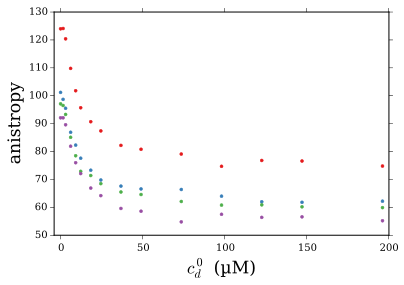

In [23]:
# Get color scheme for plot
from brewer2mpl import qualitative
bmap = qualitative.Set1[4]

# Plot all of the competition curves
for i in range(len(r_comp)):
    plt.plot(c_d_0, r_comp[i], '.', color=bmap.mpl_colors[i])
plt.margins(x=0.02)
plt.xlabel(u'$c_d^0$ (µM)')
plt.ylabel('anistropy')

It's hard to guess a value of $K_d$ from this, plot, but we will guess that it is close to $K_d^*$ and say $K_d \approx 0.2$ µM.  It looks like $r_f$ is again about 60 and $r_b$ is again about 100 or 120, so we will guess 110.  We are now ready to fit our curves!

In [24]:
# Generate initial guess
K_d_0 = 0.2   # uM
K_d_star_0 = K_d_star_diss
r_f_0 = 50.0
r_b_0 = 100.0
p0 = np.array([K_d_0, K_d_star_0, r_f_0, r_b_0])

# Initialize list to store popts.
popt_comp = []
err_comp = []

# Fit each of the four curves and compute error bars
for i in range(len(r_comp)):
    args = (c_d_0, r_comp[i], K_d_star_diss, K_d_star_diss_err, c_a_0,
            c_d_star_0)
    opt_result = scipy.optimize.minimize(neg_log_post_comp, p0, args,
                                         method='Powell')
    if opt_result.success:
        popt_comp.append(opt_result.x)
        
        # Compute error bar
        hess = jb.hess_nd(log_post_comp, opt_result.x, args)
        cov = -np.linalg.inv(hess)
        err_comp.append(np.sqrt(np.diag(cov)))
    else:
        print('Optimization failed with message: %s' % opt_result.message)
        raise RuntimeError('Optimization failed!')

# Convert optimial params and error bars to NumPy arrays for easy indexing.
popt_comp = np.array(popt_comp)
err_comp = np.array(err_comp)

Now, we'll report the results and also make a bar graph of all the results.  I'll use `pandas`'s plotting tools to do it, since I like the way it is formatted better than standard `matplotlib`.


Trial            K_d (µM)            K_d_star (µM)
=====         ==============        ===============
  1           0.654 +- 0.060        0.162 +- 0.009
  2           0.584 +- 0.046        0.163 +- 0.009
  3           0.565 +- 0.052        0.162 +- 0.009
  4           0.682 +- 0.074        0.163 +- 0.009



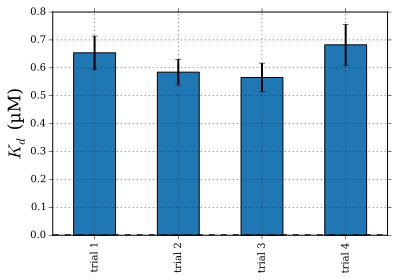

In [25]:
# Print results
formats = []
for i in range(4):
    formats.extend([popt_comp[i,0], err_comp[i,0], 
                    popt_comp[i,1], err_comp[i,1]])
formats = tuple(formats)
print("""
Trial            K_d (µM)            K_d_star (µM)
=====         ==============        ===============
  1           {0:.3f} +- {1:.3f}        {2:.3f} +- {3:.3f}
  2           {4:.3f} +- {5:.3f}        {6:.3f} +- {7:.3f}
  3           {8:.3f} +- {9:.3f}        {10:.3f} +- {11:.3f}
  4           {12:.3f} +- {13:.3f}        {14:.3f} +- {15:.3f}
""".format(*formats))

# Make a bar chart of K_d values with error bars
df_bar = pd.DataFrame(data=popt_comp[:,0],
                      index=['trial 1', 'trial 2', 'trial 3', 'trial 4'])
df_err = pd.DataFrame(data=err_comp[:,0],
                      index=['trial 1', 'trial 2', 'trial 3', 'trial 4'])
fig, ax = plt.subplots()
df_bar.plot(yerr=df_err, ax=ax, kind='bar', legend=False)
plt.ylabel(u'$K_d$ (µM)');

It is perhaps reassuring that all of the $K_d$'s are within one standard deviation of each other.  We can compute our resultant $K_d$ and its error bar just as we did the $K_d^*$ for the dissociation case.

In [26]:
# Compute error bar first
K_d_err = np.sqrt(1.0 / (1.0 / err_comp[:,0]**2).sum())

# Compute most probable K_d as mean weighted with variances
K_d = K_d_err**2 * (popt_comp[:,0] / err_comp[:,0]**2).sum()

# Report result
print(u'K_d = %.2f +- %.2f µM' % (K_d, K_d_err))

K_d = 0.61 +- 0.03 µM


So, we got what we were after.

\begin{align}
K_d = 0.61 \pm 0.03 \text{ µM}.
\end{align}

Finally, let's plot our fitted curves over the data.

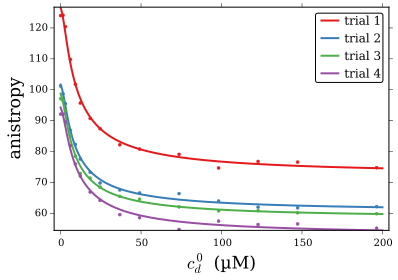

In [27]:
# Get a list of nice ColorBrewer colors
# (I don't like to use lightest colors, hence choosing 7 instead of 5)
from brewer2mpl import qualitative
bmap = qualitative.Set1[4]

# Generate smooth curves
c_d_0_smooth = np.linspace(0.0, 200.0, 200)
r_smooth = np.empty((len(c_d_0_smooth), 4))
for i in range(4):
    r_smooth[:,i] = r_comp_array(popt_comp[i,0], popt_comp[i,1], 
                                 c_a_0, c_d_0_smooth, c_d_star_0,
                                 popt_comp[i,2], popt_comp[i,3])

# Plot all of the competition curves
for i in range(len(r_comp)):
    plt.plot(c_d_0, r_comp[i], '.', color=bmap.mpl_colors[i])
    plt.plot(c_d_0_smooth, r_smooth[:,i], '-', color=bmap.mpl_colors[i],
             label='trial %d' % (i+1))
    plt.margins(x=0.02)
    plt.legend(loc='upper right')
plt.xlabel(u'$c_d^0$ (µM)')
plt.ylabel('anistropy');

We could have done these regressions all at once, either by optimization or using MCMC.  In part (f), I will do everything at once, including the dissociation assays, using MCMC.

**f)** To compute all the regressions at once, we'll use MCMC.  We start by defining our log posterior.  Since all the experiments are independent, we multiply the likelihoods.  We also assume the values of $r_f$ and $r_b$ are independent for each trial, so their priors are multiplied.  Finally, we assume that each trial has a spread in the data, $\sigma$, that is independent of the other trials.  This may not be the best assumption because the trials are all done on the same instrument, so there may be some relationship between the $\sigma$'s from experiment to experiment.

In [28]:
# Define log_posterior
def log_posterior(p, c_a_0_diss, c_a_0_comp, c_d_0, r_diss, r_comp, 
                  c_d_star_0):
    """
    Log of the posterior with
    p[0] = K_d
    p[1] = K_d_star
    p[2:8] = r_f values
    p[8:14] = r_b values
    p[14:20] = sigma values
    
    c_a_0_diss and r_diss are lists containing the dissociation data
    c_d_0 is values of S_D that competition titration used.
    r_comp is list containing the competition data
    """
    # Check to make sure in range of priors
    if (p <= 0.0).any():
        return -np.inf
    
    # Unpack parameters
    K_d, K_d_star = p[0:2]
    r_f_diss = p[2:4]
    r_f_comp = p[4:8]
    r_b_diss = p[8:10]
    r_b_comp = p[10:14]
    sigma_diss = p[14:16]
    sigma_comp = p[16:]
        
    # Theoretical curves for dissociation experiments
    r_theor_diss = []
    for i in range(2):
        r_theor_diss.append(r_diss_array(K_d_star, c_a_0_diss[i], c_d_star_0, 
                                   r_f_diss[i], r_b_diss[i]))

    # Theoretical curves for competition experiments
    r_theor_comp = []
    for i in range(4):
        r_theor_comp.append(r_comp_array(
            K_d, K_d_star, c_a_0_comp, c_d_0, c_d_star_0, r_f_comp[i], 
            r_b_comp[i]))

    # Construct posterior, starting with priors on K_d and K_d_star
    log_post = -np.log(K_d_star) - np.log(K_d)
    
    # Add in sigma priors and Gaussian normalizations
    for i in range(2):
        log_post -= (len(c_a_0_diss[i]) + 1) * np.log(sigma_diss[i])
    for i in range(4):
        log_post -= (len(c_d_0) + 1) * np.log(sigma_comp[i])

    # Add in Gaussian likelihoods
    for i in range(2):
        log_post -= ((r_diss[i] - r_theor_diss[i])**2).sum() \
                            / 2.0 / sigma_diss[i]**2
    for i in range(4):
        log_post -= ((r_comp[i] - r_theor_comp[i])**2).sum() \
                            / 2.0 / sigma_comp[i]**2

    return log_post

Now that we have the log posterior, we just have to set up the MCMC calculation and let 'er rip!

In [29]:
# Set up input arrays that aren't already set up
c_a_0_diss = [c_a_0_diss_1, c_a_0_diss_2]
r_diss = [r_diss_1, r_diss_2]
c_a_0_comp = c_a_0

# MCMC parameters
n_dim = 20        # 20 total parameters
n_walkers = 50    # number of MCMC walkers
n_burn = 2000      # "burn-in" period to let chains stabilize
n_steps = 50000    # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# We'll randomize in a Gaussian fashion about our guesses.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.lognormal(np.log(0.3), 0.3, n_walkers)  # K_d_star
p0[:,1] = np.random.lognormal(np.log(0.3), 0.3, n_walkers)  # K_d
p0[:,2:8] = np.random.normal(60.0, 5.0, (n_walkers, 6))     # r_f
p0[:,8:14] = np.random.normal(110.0, 5.0, (n_walkers, 6))   # r_b
p0[:,14:] = np.random.exponential(1.0, (n_walkers,6))       # sigma

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, log_posterior, 
    args=(c_a_0_diss, c_a_0_comp, c_d_0, r_diss, r_comp, c_d_star_0))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

After that lengthy calculation, we have a detailed description of the posterior.  We just have to pull out what we want now.  We'll start by finding the most probable values of $K_d$ and $K_d^*$.

In [30]:
# Find more probable parameters
max_ind = np.argmax(sampler.flatlnprobability)
p_mp_cum = sampler.flatchain[max_ind,:]

# Print result to the screen
print(u'most probable K_d  = %.4f µM' % p_mp_cum[0])
print(u'most probable K_d* = %.4f µM' % p_mp_cum[1])

most probable K_d  = 0.5853 µM
most probable K_d* = 0.1557 µM


These are very nearly the same most probable values we got from doing our regressions individually.

Of course, we would like to know more than the most probable values.  We would like to see the distributions.  So, let's look at the distributions of $K_d$ and $K_d^*$, as well as their joint distribution.  We can do this conveniently using `triangle`.

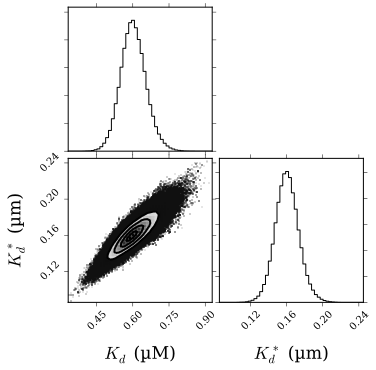

In [31]:
# Use triangle.corner to make summary plot
fig = triangle.corner(sampler.flatchain[:,:2], 
                      labels=[u'$K_d$ (µM)', u'$K_d^*$ (µm)'])

This is informative!  While they are strongly peaked around their most probable values, $K_d^*$ and $K_d$ both have tails to the right, meaning that they may both be larger than we think.  That said, the most probable $K_d$ from MCMC is a bit less than we got from numerical optimization.  This would mean they are in fact looser binders.  We also see that $K_d$ and $K_d^*$ are positively correlated.

These distributions were hard won. Not by us (the code was easy), but by the computer, which did a lot of work to generate them.  However, we get a lot more information out of the MCMC traces than simply finding the most probable values by numerical optimization and then approximating the posterior as locally Gaussian.  AS a final comparison, let's compare our approximate Gaussian pdf for $K_d$ to the MCMC result.

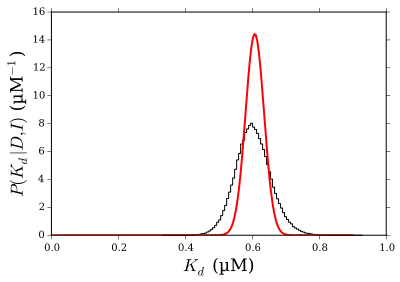

In [34]:
# Generate smooth Gaussian
x = np.linspace(0.0, 0.9, 200)
y = np.exp(-(x - K_d)**2 / 2.0 / K_d_err**2) / np.sqrt(2.0 * np.pi) / K_d_err

# Plot MCMC result as histogram and Gaussian approx from numerical result
# as a smooth curve
n, b, p = plt.hist(sampler.flatchain[:,0], normed=True, bins=100, 
                   histtype='step', color='black')
plt.plot(x, y, 'r-')
plt.xlabel(u'$K_d$ (µM)')
plt.ylabel(u'$P(K_d|D,I)$ (µM$^{-1}$)')

We see that making the Gaussian approximations results in extra tight error bars.  This is not unexpected; the Gaussian distribution falls off extremely quickly, as $x^2$ on a log plot.  So, even though any distrution is locally Gaussian at its peak, the tails are often not properly captured by a Gaussian.

In fact, is we try to capture the moments of the distribution (as described by mean, standard deviation, skew, and kurtosis), it looks different from Gaussian.

In [35]:
print("""
mean:                {0:g}
standard deviation:  {1:g}
skewness:            {2:g}
kurtosis:            {3:g}
""".format(sampler.flatchain[:,0].mean(), sampler.flatchain[:,0].std(),
           scipy.stats.skew(sampler.flatchain[:,0]),
           scipy.stats.kurtosis(sampler.flatchain[:,0])))


mean:                0.602731
standard deviation:  0.0531689
skewness:            0.204552
kurtosis:            0.39214



The skewness is a measure of how lopsided the distribution is and the kurtosis is a measure of how flat it is compared to a Gaussian.  The skew and kurtosis of a Gaussian distribution are both zero.  So, the distribution for $K_d$ is flatter and slightly more skewed to the right than a Gaussian.  Finally, we note that the mean value of K_d is close to what we got for the most probable $K_d$ from numerical optimziation.